In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

In [3]:
plotsize_subplots = (cm2inch(20),cm2inch(3))
#plotsize_subplots = (16,3)

plotsize_mem_conn_subplots = (cm2inch(20),cm2inch(5))

fontsize_axis = 10
fontsize_labels = 8

#print(plt.rcParams.keys())

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels})

# Functions

In [2]:
def cm2inch(value):
    return value/2.54

In [101]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['T_conn']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    
    if 'NUM_VPS' not in list(df):
        df['NUM_VPS'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['NUM_VPS'])/1024**2 # JEG TROR UNITEN ER FEIL
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['NUM_VPS'])/1024**2
    df['other'] = (df['VSize_sum']/df['NUM_VPS'])/1024**2 - df['connections'] - df['ini']
    df['memory_per_rank'] = (df['VSize_sum']/df['NUM_VPS'])/1024**2
    
    #print(df['connections'])
    #print(df['ini'])
    #print(df['other'])
    #print(df['connections'] + df['ini'] + df['other'])
    #print(df['memory_per_rank'])
    
    #print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])
    
    return df

In [54]:
def plot_results(df, name, df_err=None, plot_T_sim=True):
    ncols = 4
    values = ['T_conns_min', 'T_ini_min', 'T_conn']
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=['NUM_VPS'], values=values)
    df_mem = pd.pivot_table(df, index=['NUM_VPS'], values=['connections', 'ini', 'other'])
    
    if df_err is not None:
        df_err_p = pd.pivot_table(df_err, index=['NUM_VPS'], values=values)
        df_err_mem_p = pd.pivot_table(df_err, index=['NUM_VPS'], values=['connections', 'ini', 'other'])
        print(df_err_p)
    else:
        df_err_p = None
        df_err_mem_p = None
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', yerr=df_err_p, capsize=4, subplots=True, legend=False,
              ax=axes[:ncols-1], fontsize=fontsize_axis, rot=45)
    df_mem.plot(kind='bar', yerr=df_err_mem_p, capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=45, color=['purple', 'pink', 'red'])
    plt.legend(fontsize=6, loc='lower right')
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel('N_VP')
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['memory_per_rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [MiB]')
    axes[ncols-1].set_title('memory_per_rank')
    axes[ncols-1].set_xlabel('N_VP')

    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [6]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

In [87]:
def time_per_connection(df):
    #if 'T_conns_sum' in list(df):
    #    df['time_per_connection'] = (df['T_conns_sum']/df['N_conns_sum'])*1e9
    #else:
    df['time_per_connection'] = (df['T_conn']*df['NUM_VPS']/df['N_conns_sum'])*1e9
    return df

In [93]:
def memory_per_connection(df):
    df['memory_per_connection'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_conns_sum'])*1000
    return df

In [86]:
def plot_conn_and_mem(df, name):
    """Plot time per connection and memory per connection for different rules"""
    
    df_p = pd.pivot_table(df, index=['NUM_VPS', 'rule'], values=['time_per_connection', 'memory_per_connection'])
    
    # Make subplots
    axes = df_p.plot(kind='bar', subplots=True, legend=False, layout=(1,2),
                     x=df['NUM_VPS'].sort_values(ascending=True),
                     fontsize=fontsize_axis, rot=45, figsize = plotsize_mem_conn_subplots)
    
    
    color = plt.cm.Dark2(np.arange(len(df.rule.unique())))
    colors = [color[i] for i in range(len(df.rule.unique()))]*len(df)
    labels = list(df.rule.unique())
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in range(len(labels))]
    
    for ax in axes.flat:
        ax.legend(handles=handles, labels=labels, fontsize=6, loc='upper right')
        for i,bar in enumerate(ax.patches):
            bar.set_color(colors[i])
    
    #plt.subplots_adjust(wspace=0.4)
    
    # x-axis labels
    for ax in axes[0]:#i, val_name in enumerate(list(df_p)):
        ax.set_xlabel('N_VP')
    
    # y-axes labels
    axes[0][0].set_ylabel('Memory [B]')
    axes[0][1].set_ylabel('Time [ns]')

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [61]:
def plot_fixed_VP_diff_threads(df, name):
    df_p = pd.pivot_table(df, index=['THREADS_PER_TASK'],
                               values=['T_conns_min', 'T_ini_min', 'T_conn', 'T_sim'])
    df_mem_p = pd.pivot_table(df, index=['THREADS_PER_TASK'], values=['connections', 'ini', 'other'])

    # Make subplots
    ncols = 5
    fig, axes = plt.subplots(nrows=1, ncols=ncols)

    df_p.plot(kind='bar', subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis, rot=45)
    df_mem_p.plot(kind='bar', stacked=True, legend=True, ax=axes[ncols-1],
                  fontsize=fontsize_axis, rot=45, color=['purple', 'pink', 'red'])
    plt.legend(fontsize=6, loc='lower right')

    plt.subplots_adjust(wspace=0.4)

    # x- and y-axes labels
    for ax in axes:
        ax.set_xlabel('Threads')

    axes[0].set_ylabel('Time [s]')
    axes[ncols-1].set_ylabel('Memory [MiB]')
    axes[ncols-1].set_title('memory_per_rank')

    fig.savefig(name, bbox_inches='tight')

    df_p['connections'] = df_mem_p['connections']
    df_p['ini']         = df_mem_p['ini']
    df_p['other']       = df_mem_p['other'] 
    
    return df_p

# FIG. 1

## HPC_benchmark

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,99.81,54.30,42.19,191.51,2.743245,0.019534,0.055616
72,102.35,53.72,42.97,189.58,2.743245,0.024010,0.053295
144,105.35,54.19,44.75,198.40,2.743245,0.109460,0.053315
288,109.34,53.67,48.82,211.33,2.743245,0.114370,0.053327
576,120.57,52.43,60.34,231.49,2.743245,0.240082,0.053680
1152,139.73,52.39,79.09,267.39,2.743083,0.576400,0.054545


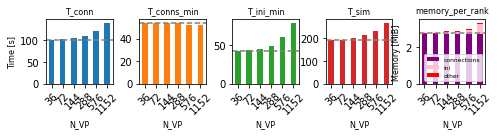

In [102]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20.csv')
#hpc_t6_s20_err1 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_err1.csv')
#hpc_t6_s20_err2 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_err2.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
#hpc_t6_s20_err1 = calculate_T_conn_and_memory(hpc_t6_s20_err1)
#hpc_t6_s20_err2 = calculate_T_conn_and_memory(hpc_t6_s20_err2)

#p = pd.Panel({n: df for n, df in enumerate([hpc_t6_s20, hpc_t6_s20_err1, hpc_t6_s20_err2])})
#err = p.std(axis=0)
#err['NUM_VPS'] = hpc_t6_s20['NUM_VPS']

hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf')

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
hpc_t6_s20_p

### HPC few neurons
SCALE = 1*NUMBER_OF_NODES

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,0.81,0.27,0.37,3.63,0.013021,0.020592,0.042297
72,1.25,0.54,0.63,4.47,0.031087,0.018856,0.052536
144,2.52,1.09,1.24,5.20,0.060384,0.022518,0.048880
288,4.93,2.14,2.45,6.19,0.108236,0.031125,0.054357
576,6.55,2.65,3.45,6.94,0.132324,0.062850,0.046763
1152,7.18,2.61,4.06,16.91,0.132758,0.091655,0.045444


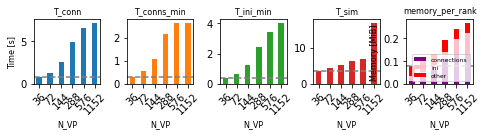

In [84]:
hpc_t6_s1 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s1.csv')

hpc_t6_s1 = calculate_T_conn_and_memory(hpc_t6_s1)

hpc_t6_s1_p = plot_results(hpc_t6_s1, 'benchmark_figures/hpc_benchmark_few_neurons.pdf')

save_table_latex(hpc_t6_s1_p.to_latex(), 'latex_tables/hpc_benchmark_few_neurons_table.txt')
hpc_t6_s1_p

## HPC delay 0.1 - 50.

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,103.50,53.56,45.38,134.70,1.930745,0.392907,0.051058
72,107.41,51.74,46.95,133.91,1.930745,0.392907,0.053295
144,105.05,52.82,46.63,147.27,1.930745,0.394128,0.053315
288,111.17,52.01,50.14,167.28,1.930745,0.477530,0.053327
576,128.82,52.04,66.64,221.18,1.951579,0.459646,0.053680
1152,147.11,52.05,85.56,353.64,1.993083,0.460135,0.054545


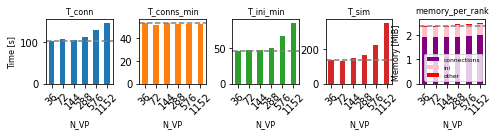

In [56]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_diff_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_diff_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

None


,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,103.50,53.56,45.38,134.70,1.930745,0.392907,0.051058
72,107.41,51.74,46.95,133.91,1.930745,0.392907,0.053295
144,105.05,52.82,46.63,147.27,1.930745,0.394128,0.053315
288,111.17,52.01,50.14,167.28,1.930745,0.477530,0.053327
576,128.82,52.04,66.64,221.18,1.951579,0.459646,0.053680
1152,147.11,52.05,85.56,353.64,1.993083,0.460135,0.054545


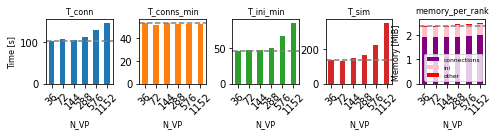

In [30]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_static_delays.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static_diff_delays.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_diff_delays_table.txt')
hpc_static_t6_s20_p

## HPC Split into many Connect calls

None


,T_conn,T_conns_min,T_ini_min,connections,ini,other
NUM_VPS,,,,,,
36,140.69,93.72,43.75,2.743245,0.018721,0.058383
72,141.95,95.04,44.08,2.743245,0.038740,0.127677
144,149.15,97.74,45.64,2.743245,0.103275,0.231606
288,160.06,102.46,48.82,2.743245,0.104300,0.458369
576,178.35,112.52,57.72,2.743245,0.181957,0.399136
1152,219.40,133.32,77.62,2.743083,0.553613,0.257282


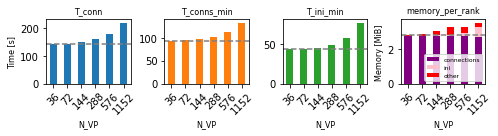

In [31]:
hpc_split_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split.csv')

hpc_split_t6_s20 = calculate_T_conn_and_memory(hpc_split_t6_s20)
hpc_split_t6_s20_p = plot_results(hpc_split_t6_s20, 'benchmark_figures/hpc_benchmark_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_table.txt')
hpc_split_t6_s20_p

## HPC split into many Connect calls, increasing number of NBLOCKS

None


,T_conn,T_conns_min,T_ini_min,connections,ini,other
NUM_VPS,,,,,,
36,141.45,93.72,43.51,2.743245,0.016279,0.057569
72,289.88,231.57,43.54,2.743245,0.040368,0.125398
144,847.58,753.47,42.66,2.826579,0.019128,0.214502
288,3124.88,2744.99,44.27,2.933350,0.116690,0.336835
576,NaN,NaN,NaN,NaN,NaN,NaN
1152,NaN,NaN,NaN,NaN,NaN,NaN


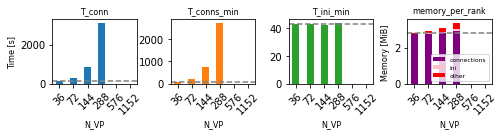

In [32]:
hpc_split_increase_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split_increase.csv')

hpc_split_increase_t6_s20 = calculate_T_conn_and_memory(hpc_split_increase_t6_s20)
hpc_split_increase_t6_s20_p = plot_results(hpc_split_increase_t6_s20,
                                           'benchmark_figures/hpc_benchmark_split_increase.pdf', plot_T_sim=False)

save_table_latex(hpc_split_increase_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_increase_table.txt')
hpc_split_increase_t6_s20_p

## Population model

None


,T_conn,T_conns_min,T_ini_min,connections,ini,other
NUM_VPS,,,,,,
36,86.77,44.25,39.58,1.982666,0.095207,0.062289
72,88.60,44.43,40.50,1.978109,0.139478,0.068432
144,91.95,46.16,41.46,1.978109,0.220167,0.068452
288,95.33,48.49,43.75,1.978109,0.124685,0.068463
576,110.80,53.36,54.05,1.978109,0.398448,0.068817
1152,172.28,64.57,96.74,1.978109,0.443953,0.069519


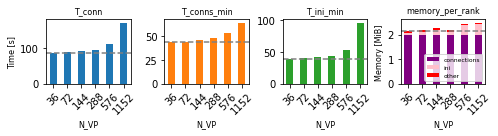

In [33]:
population = pd.read_csv('benchmark_results/population_model_conn_sort_update_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')
population_p

## Multi-Area Model

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,157.306587,118.479932,38.826491,1141.184268,2.551994,0.057675,-1.942890e-16
72,200.466683,162.750995,37.715194,1415.311204,2.552712,0.096167,9.168837e-03
144,285.568365,245.596020,39.971991,1674.480795,2.553383,0.181332,6.388346e-03
288,455.648637,411.628427,44.018951,2008.395862,2.625877,0.247732,-5.551115e-17
576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1152,1527.222877,1463.018885,64.201841,3023.417031,2.939623,0.456360,2.220446e-16


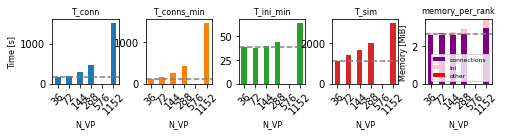

In [113]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_conn_sort_update_daint_t6_s0_0625.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=True)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')
MAM_t6_s0_0625_p

## 4x4 mesocircuit

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,NUM_VPS,hash,num_tasks,T_nrns,T_conns_avg,T_conns_min,...,N_spks_sum,N_nrns,N_conns_sum,T_bld_xn,T_bld_nx,T_conn,connections,ini,other,memory_per_rank
0,1,6,6,0.0625,36,acd429db3b9ab17b5f5391184e500dc6,6,0.55,169.435000,169.10,...,560690,77169,345443323,175.15,175.65,175.15,0.502441,0.112576,0.049678,0.664696
1,2,6,6,0.1250,72,acd429db3b9ab17b5f5391184e500dc6,12,0.94,193.399167,193.27,...,1231702,154338,690927633,199.94,200.46,199.94,0.521647,0.103027,0.063959,0.688634
2,4,6,6,0.2500,144,acd429db3b9ab17b5f5391184e500dc6,24,2.18,227.260833,226.92,...,2725785,308676,1381963143,234.20,234.88,234.20,0.540202,0.123834,0.075698,0.739733
3,8,6,6,0.5000,288,acd429db3b9ab17b5f5391184e500dc6,48,3.88,330.619792,330.18,...,5629041,617352,2763938640,338.22,339.09,338.22,0.455751,0.173929,0.103053,0.732733
4,16,6,6,1.0000,576,acd429db3b9ab17b5f5391184e500dc6,96,7.97,519.575833,519.27,...,10859878,1234704,5527888387,529.73,530.76,529.73,0.409619,0.233214,0.171115,0.813949
5,32,6,6,2.0000,1152,acd429db3b9ab17b5f5391184e500dc6,192,21.36,927.114583,926.42,...,21690611,2469408,11055874121,940.37,942.03,940.37,0.410835,0.363299,0.303653,1.077786


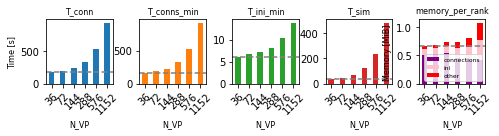

In [106]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_conn_sort_update_daint_t6_s0_0625.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=True)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')
meso_t6_s0_0625

# FIG. 2
Compare different connection rules

memory_per_connection  time_per_connection
NUM_VPS rule                                                 
36      bernoulli              40.908003          1940.089396
        indegree               40.906589          1517.802262
        outdegree                    NaN                  NaN
72      bernoulli              40.907134          2562.934243
        indegree               40.906597          1547.808778
        outdegree                    NaN                  NaN
144     bernoulli              40.906575          3673.697436
        indegree               40.906601          1561.034421
        outdegree                    NaN                  NaN
288     bernoulli              40.906233          6054.802209
        indegree               40.906603          1568.998234
        outdegree                    NaN                  NaN
576     bernoulli                    NaN                  NaN
        indegree               40.906604          1739.791976
        outdegree                    NaN                  NaN
1152    bernoulli              40.904242         20194.503133
        indegree               40.904177          2062.749952
        outdegree                    NaN                  NaN

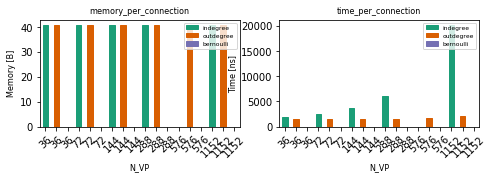

In [110]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_in.csv')
hpc_in['rule'] = ['indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_out.csv')
hpc_out['rule'] = ['outdegree']*len(hpc_out)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_bern.csv')
hpc_bern['rule'] = ['bernoulli']*len(hpc_bern)

hpc_rules = pd.concat([hpc_in, hpc_out, hpc_bern])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_per_connection(hpc_rules)
hpc_rules = memory_per_connection(hpc_rules)

hpc_rules_p = plot_conn_and_mem(hpc_rules, 'benchmark_figures/hpc_rules.pdf')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_table.txt')

hpc_rules_p

# FIG. 3
Compare hpc with few neurons per node and hpc with many neurons per node

memory_per_connection  time_per_connection
NUM_VPS rule                                                    
36      few neurons               38.798595          2301.772112
        many neurons              40.906589          1419.393271
72      few neurons               46.339141          1776.952921
        many neurons              40.906597          1455.514778
144     few neurons               45.015434          1791.593021
        many neurons              40.906601          1498.177792
288     few neurons               40.348652          1752.691982
        many neurons              40.906603          1554.919486
576     few neurons               39.463708          1862.944596
        many neurons              40.906604          1714.620880
1152    few neurons               39.593160          2042.129084
        many neurons              40.904177          1987.094456

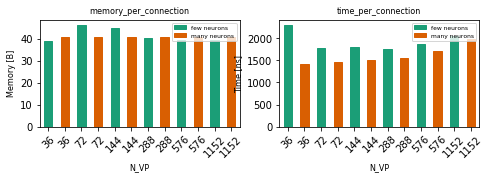

In [95]:
hpc_t6_s1['rule']  = ['few neurons']*len(hpc_t6_s1)
hpc_t6_s20['rule'] = ['many neurons']*len(hpc_t6_s20)

hpc_few_many = pd.concat([hpc_t6_s1, hpc_t6_s20])

hpc_few_many = time_per_connection(hpc_few_many)
hpc_few_many = memory_per_connection(hpc_few_many)

hpc_few_many_p = plot_conn_and_mem(hpc_few_many, 'benchmark_figures/hpc_few_many.pdf')
save_table_latex(hpc_few_many_p.to_latex(), 'latex_tables/hpc_few_many_table.txt')

hpc_few_many_p

# FIG. 4
Compare nblocks and population

memory_per_connection  time_per_connection
NUM_VPS rule                                                          
36      NBLOCKS                         41.085523          2009.497507
        increasing NBLOCKS              41.085523          2020.352707
        population                      29.937254          1249.488000
72      NBLOCKS                         41.085531          2027.494688
        increasing NBLOCKS              41.085531          4140.402678
        population                      29.868442          1275.840000
144     NBLOCKS                         41.085535          2130.333658
        increasing NBLOCKS              43.901238         12554.414558
        population                      29.868442          1324.080000
288     NBLOCKS                         41.085537          2286.163072
        increasing NBLOCKS              47.311514         48065.830926
        population                      29.868442          1372.752000
576     NBLOCKS                         41.085538          2547.402186
        increasing NBLOCKS                    NaN                  NaN
        population                      29.868442          1595.520000
1152    NBLOCKS                         41.083101          3133.726081
        increasing NBLOCKS                    NaN                  NaN
        population                      29.868442          2480.832000

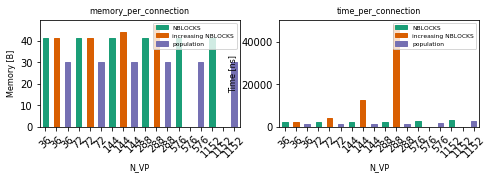

In [96]:
hpc_split_t6_s20['rule']          = ['NBLOCKS']*len(hpc_split_t6_s20)
hpc_split_increase_t6_s20['rule'] = ['increasing NBLOCKS']*len(hpc_split_increase_t6_s20)
population['rule']                = ['population']*len(population)

increasing_conns = pd.concat([hpc_split_t6_s20, hpc_split_increase_t6_s20, population])

increasing_conns = time_per_connection(increasing_conns)
increasing_conns = memory_per_connection(increasing_conns)

increasing_conns_p = plot_conn_and_mem(increasing_conns, 'benchmark_figures/increasing_conns.pdf')
save_table_latex(increasing_conns_p.to_latex(), 'latex_tables/increasing_conns_table.txt')

increasing_conns_p

# FIG. 5
Comapare hpc, MAM and 4x4

memory_per_connection  time_per_connection
NUM_VPS rule                                            
36      4x4               54.904891         18253.066654
        MAM               63.864572          3754.285504
        hpc               40.906589          1419.393271
72      4x4               57.000239         20835.293470
        MAM               63.882441          4784.339126
        hpc               40.906597          1455.514778
144     4x4               59.023097         24403.545182
        MAM               63.899183          6815.371506
        hpc               40.906601          1498.177792
288     4x4               49.795710         35242.229545
        MAM               65.713356         10874.501463
        hpc               40.906603          1554.919486
576     4x4               44.755161         55197.293910
        MAM                     NaN                  NaN
        hpc               40.906604          1714.620880
1152    4x4               44.887585         97984.675670
        MAM               73.564909         36448.661236
        hpc               40.904177          1987.094456

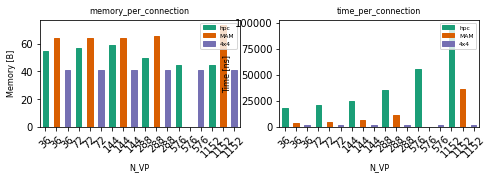

In [107]:
hpc_t6_s20['rule']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['rule']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['rule'] = ['4x4']*len(meso_t6_s0_0625)

hpc_MAM_4x4 = pd.concat([hpc_t6_s20, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_MAM_4x4 = time_per_connection(hpc_MAM_4x4)
hpc_MAM_4x4 = memory_per_connection(hpc_MAM_4x4)
hpc_MAM_4x4_p = plot_conn_and_mem(hpc_MAM_4x4, 'benchmark_figures/hpc_MAM_4x4.pdf')
save_table_latex(hpc_MAM_4x4_p.to_latex(), 'latex_tables/hpc_MAM_4x4_table.txt')

hpc_MAM_4x4_p

# FIG. 6
Fixed VP, different threads

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
THREADS_PER_TASK,,,,,,,
1,NaN,22.19,NaN,NaN,2.716797,NaN,NaN
3,100.70,38.16,49.48,271.22,2.739258,0.685848,0.101684
6,145.46,52.58,85.38,280.44,2.743083,0.590325,0.054557
9,203.68,56.10,142.77,276.90,2.742622,0.566051,0.043944
18,506.47,74.29,426.64,295.89,2.751028,0.518179,0.032272
36,1545.11,109.58,1430.94,392.68,2.759644,0.515601,0.027414


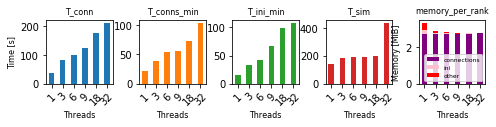

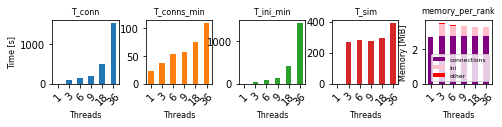

In [109]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_s20_threads.csv')
hpc_threads_n36 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_threads_n36.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)
hpc_threads_n36 = calculate_T_conn_and_memory(hpc_threads_n36)

hpc_threads_n1_p = plot_fixed_VP_diff_threads(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf')
hpc_threads_n36_p = plot_fixed_VP_diff_threads(hpc_threads_n36, 'benchmark_figures/hpc_fixedVP_diff_threads_n36.pdf')

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
save_table_latex(hpc_threads_n36_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n36_table.txt')
#hpc_threads_n1_p
hpc_threads_n36_p